In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from typing import Literal, Tuple
import re
import mteb
import os

In [40]:
FILTER = [
    "run15-chemical-finetune-pair",
    "run22-chemical-finetune-pair",
    "run23-chemical-finetune-pair",
    "run24-chemical-finetune-pair",
]

In [9]:
def extract_number(s):
    m = re.search(r'\d+', s)
    return int(m.group()) if m else float('inf')

In [10]:
def get_task_type(task_name):
    task = mteb.get_tasks(tasks=[task_name])[0]
    return task.metadata.type

In [11]:
def find_highest_score(df: pd.DataFrame) -> tuple[str, float]:
    max_index = df.iloc[:, 1].idxmax()
    max_score = df.iloc[:, 1].max()
    corresponding_string = df.iloc[max_index, 0]
    return corresponding_string, max_score

In [12]:
def find_highest_score(
    df: pd.DataFrame,
    filter_by: Literal['epoch', 'step', 'both'] = 'both'
) -> Tuple[str, float]:
    """
    Return the label and value of the highest score in column 1,
    optionally filtering to only 'epoch_*' or 'step_*' rows.

    Parameters
    ----------
    df : pd.DataFrame
        Two-column DataFrame where
        - col 0 contains strings like 'epoch_1', 'step_38', etc.
        - col 1 contains numeric scores.
    filter_by : {'epoch', 'step', 'both'}
        What to include in the search:
        - 'epoch': only rows whose label starts with 'epoch_'
        - 'step' : only rows whose label starts with 'step_'
        - 'both' : no filtering (default)

    Returns
    -------
    label : str
        The string (from col 0) corresponding to the highest score.
    max_score : float
        The highest score found in col 1.
    """
    if filter_by == 'epoch':
        mask = df.iloc[:, 0].str.startswith('epoch_')
    elif filter_by == 'step':
        mask = df.iloc[:, 0].str.startswith('step_')
    elif filter_by == 'both':
        mask = pd.Series(True, index=df.index)
    else:
        raise ValueError(f"filter_by must be 'epoch', 'step' or 'both'; got {filter_by!r}")

    filtered = df.loc[mask]

    if filtered.empty:
        raise ValueError(f"No rows matched filter '{filter_by}'")

    max_idx = filtered.iloc[:, 1].idxmax()
    max_score = filtered.iloc[:, 1].max()
    label = df.at[max_idx, df.columns[0]]

    return label, max_score

Find the run with highest score

In [13]:
def find_highest_score(
    df: pd.DataFrame,
    filter_by: Literal['epoch', 'step', 'both'] = 'both'
) -> Tuple[str, float]:
    """
    Return the label and value of the highest score in column 'score',
    optionally filtering by 'epoch_' or 'step_' prefixes—but if no such
    labels exist, fall back to considering all rows.

    Parameters
    ----------
    df : pd.DataFrame
        A two-column DataFrame where
        - the first column is some kind of label (string),
        - the second column is the score (float).
        It may or may not have headers.
    filter_by : {'epoch', 'step', 'both'}
        - 'epoch': only rows whose label starts with 'epoch_'
        - 'step' : only rows whose label starts with 'step_'
        - 'both' : no filtering

    Returns
    -------
    label : str
        The label for the highest-scoring row.
    max_score : float
        That highest score.

    Raises
    ------
    ValueError
        If after filtering there are no rows at all.
    """

    df = df.rename(columns={df.columns[0]: "label", df.columns[1]: "score"})

    if filter_by in ('epoch', 'step'):
        prefix = f"{filter_by}_"
        mask = df['label'].str.startswith(prefix)
        if not mask.any():
            # fallback: no matching labels, so we just consider everything
            mask = pd.Series(True, index=df.index)
    elif filter_by == 'both':
        mask = pd.Series(True, index=df.index)
    else:
        raise ValueError(f"filter_by must be 'epoch', 'step' or 'both'; got {filter_by!r}")

    filtered = df.loc[mask]
    if filtered.empty:
        raise ValueError(f"No rows found after applying filter '{filter_by}'")

    max_idx = filtered['score'].idxmax()
    return df.at[max_idx, 'label'], df.at[max_idx, 'score']

In [17]:
def extract_best_steps(path: str, filter_by: Literal['epoch', 'step', 'both'] = 'both') -> dict[str, str]:
    """
    Extract the best step/epoch for each model folder in the given benchmark path.
    
    Parameters
    ----------
    path : str
        Path to directory containing experiment folders (e.g., 'ChemRxivRetrieval')
    filter_by : {'epoch', 'step', 'both'}
        What to include in the search:
        - 'epoch': only rows whose label starts with 'epoch_'
        - 'step' : only rows whose label starts with 'step_'
        - 'both' : no filtering (default)
    
    Returns
    -------
    dict[str, str]
        Dictionary where keys are folder names (model names) and values are 
        the step/epoch names where the model got the best score
    """
    best_steps = {}
    
    for folder in os.listdir(path):
        folder_path = os.path.join(path, folder)
        if os.path.isdir(folder_path):
            means_file = os.path.join(folder_path, "mean_scores.csv")
            if os.path.isfile(means_file):
                # Read the mean scores file and determine the best run
                mean_df = pd.read_csv(means_file)
                step, score = find_highest_score(mean_df, filter_by)
                best_steps[folder] = step
    
    return best_steps


In [43]:
def best_run_mean_score(path: str,
                        filter_by: Literal['epoch', 'step', 'both'] = 'both',
                        step_dict: dict[str, str] = None,
                        filter_runs: list[str] = None) -> pd.DataFrame:
    """
    Iterate over subdirectories of the given path. For each experiment,
    if mean_scores.csv exists, load it and find the highest score using find_highest_score
    or use provided step_dict to determine which step to use.
    Returns a DataFrame with experiment names as index and their best scores.

    Parameters
    ----------
    path : str
        Path to directory containing experiment folders
    filter_by : {'epoch', 'step', 'both'}
        What to include in the search (used only when step_dict is None):
        - 'epoch': only rows whose label starts with 'epoch_'
        - 'step' : only rows whose label starts with 'step_'
        - 'both' : no filtering (default)
    step_dict : dict[str, str], optional
        Dictionary mapping folder names to specific step/epoch names.
        When provided, these steps will be used instead of find_highest_score.
        If a folder is not in the dict, falls back to find_highest_score.
    filter_runs : list[str], optional
        List of run names to include. Only affects folders starting with 'run'.
        If None, all runs are included. Non-run folders are always included.

    Returns
    -------
    pd.DataFrame
        DataFrame with experiment names as index and columns 'step' and 'score'
    """
    results = []

    for folder in os.listdir(path):
        folder_path = os.path.join(path, folder)
        if os.path.isdir(folder_path):
            # Apply run filtering: skip if folder starts with 'run' and is not in filter_runs
            if folder.startswith('run') and filter_runs is not None and folder not in filter_runs:
                continue
                
            means_file = os.path.join(folder_path, "mean_scores.csv")
            if os.path.isfile(means_file):
                mean_df = pd.read_csv(means_file)

                # Determine which step to use
                if (step_dict is not None) and (folder in step_dict):
                    step = step_dict[folder]
                    mean_df_indexed = mean_df.rename(
                        columns={mean_df.columns[0]: "label", mean_df.columns[1]: "score"})
                    matching_rows = mean_df_indexed[mean_df_indexed['label'] == step]
                    if not matching_rows.empty:
                        score = matching_rows['score'].iloc[0]
                    else:
                        step, score = find_highest_score(mean_df, filter_by)
                else:
                    step, score = find_highest_score(mean_df, filter_by)

                results.append({
                    "exp": folder,
                    "step": step,
                    "score": score
                })

    results_df = pd.DataFrame(results)
    if not results_df.empty:
        results_df.set_index("exp", inplace=True)
    return results_df.sort_index(key=lambda x: x.map(extract_number))

In [45]:
best_run_mean_score('chemteb', 'epoch', filter_runs=FILTER)

,step,score
exp,,
nomic-ai__nomic-embed-text-v1-unsupervised,nomic-ai__nomic-embed-text-v1-unsupervised,0.725110
nomic-ai__nomic-embed-text-v1,nomic-ai__nomic-embed-text-v1,0.733983
run15-chemical-finetune-pair,epoch_9,0.724461
run22-chemical-finetune-pair,epoch_2,0.711291
run23-chemical-finetune-pair,epoch_0,0.719038
run24-chemical-finetune-pair,epoch_2,0.711707


In [46]:
best_run_mean_score('ChemRxivRetrieval', 'epoch', filter_runs=FILTER)

,step,score
exp,,
nomic-ai__nomic-embed-text-v1-unsupervised,nomic-ai__nomic-embed-text-v1-unsupervised,0.81445
BAAI__bge-base-en-v1.5,BAAI__bge-base-en-v1.5,0.74373
multi-qa-mpnet-base-dot-v1,multi-qa-mpnet-base-dot-v1,0.74083
nomic-ai__nomic-embed-text-v1,nomic-ai__nomic-embed-text-v1,0.82089
nomic-ai__nomic-embed-text-v1.5,nomic-ai__nomic-embed-text-v1.5,0.78259
NovaSearch__stella_en_1.5B_v5,NovaSearch__stella_en_1.5B_v5,0.80224
BAAI__bge-small-en-v1.5,BAAI__bge-small-en-v1.5,0.71868
BAAI__bge-large-en-v1.5,BAAI__bge-large-en-v1.5,0.76281
bedrock__amazon-titan-embed-text-v1,bedrock__amazon-titan-embed-text-v1,0.66495


In [47]:
chemrxiv_best = extract_best_steps('ChemRxivRetrieval', 'epoch')
best_run_mean_score('mteb-v2', 'epoch', step_dict=chemrxiv_best, filter_runs=FILTER)

,step,score
exp,,
nomic-ai__nomic-embed-text-v1-unsupervised,nomic-ai__nomic-embed-text-v1-unsupervised,0.622593
nomic-ai__nomic-embed-text-v1,nomic-ai__nomic-embed-text-v1,0.646807
run15-chemical-finetune-pair,epoch_9,0.626262
run22-chemical-finetune-pair,epoch_11,0.608524
run23-chemical-finetune-pair,epoch_11,0.611372
run24-chemical-finetune-pair,epoch_2,0.616640


In [48]:
def best_run_mean_task_type(path: str,
                            filter_by: Literal['epoch', 'step', 'both'] = 'both',
                            step_dict: dict[str, str] = None,
                            filter_runs: list[str] = None) -> pd.DataFrame:
    """
    Iterate over subdirectories of the given path. For each experiment,
    first it finds the best run based on `mean_scores.csv`, loads the corresponding
    column from `raw_scores.csv`, and then groups the tasks (rows) by their task type,
    taking the mean score per group. Returns a DataFrame where rows are experiments
    (or model names) and columns are task categories.
    
    Parameters
    ----------
    path : str
        Path to directory containing experiment folders
    filter_by : {'epoch', 'step', 'both'}
        What to include in the search (used only when step_dict is None):
        - 'epoch': only rows whose label starts with 'epoch_'
        - 'step' : only rows whose label starts with 'step_'
        - 'both' : no filtering (default)
    step_dict : dict[str, str], optional
        Dictionary mapping folder names to specific step/epoch names.
        When provided, these steps will be used instead of find_highest_score.
        If a folder is not in the dict, falls back to find_highest_score.
    filter_runs : list[str], optional
        List of run names to include. Only affects folders starting with 'run'.
        If None, all runs are included. Non-run folders are always included.
    """
    results = []

    for folder in os.listdir(path):
        folder_path = os.path.join(path, folder)
        if os.path.isdir(folder_path):
            # Apply run filtering: skip if folder starts with 'run' and is not in filter_runs
            if folder.startswith('run') and filter_runs is not None and folder not in filter_runs:
                continue
                
            means_file = os.path.join(folder_path, "mean_scores.csv")
            raw_file = os.path.join(folder_path, "raw_scores.csv")
            # Ensure both files exist for this experiment
            if os.path.isfile(means_file) and os.path.isfile(raw_file):
                # Read the mean scores file
                mean_df = pd.read_csv(means_file)
                
                # Determine which step to use
                if (step_dict is not None) and (folder in step_dict):
                    step = step_dict[folder]
                    # We don't need the score here, just the step name
                else:
                    step, score = find_highest_score(mean_df, filter_by)

                raw_df = pd.read_csv(raw_file)
                raw_df.set_index(raw_df.columns[0], inplace=True)

                try:
                    best_run_scores = raw_df[step]
                except KeyError:
                    # If step from step_dict is not found, fallback to find_highest_score
                    if (step_dict is not None) and (folder in step_dict):
                        step, score = find_highest_score(mean_df, filter_by)
                        best_run_scores = raw_df[step]
                    else:
                        best_col_idx = raw_df.columns.get_loc(step)
                        best_run_scores = raw_df.iloc[:, best_col_idx]

                # Group the best run scores by task type (using get_task_type) and calculate the mean
                grouped_means = best_run_scores.groupby(lambda task: get_task_type(task)).mean()

                # Store the experiment name and the grouped means as a row in our results
                experiment_result = {"experiment": folder}
                experiment_result.update(grouped_means.to_dict())
                results.append(experiment_result)

    results_df = pd.DataFrame(results)
    if not results_df.empty:
        results_df.set_index("experiment", inplace=True)
    return results_df.sort_index(key=lambda x: x.map(extract_number))

In [49]:
best_run_mean_task_type('chemteb', 'epoch', filter_runs=FILTER)

,BitextMining,Classification,Clustering,PairClassification,Retrieval
experiment,,,,,
nomic-ai__nomic-embed-text-v1-unsupervised,0.000696,0.822284,0.566424,0.632620,0.651250
nomic-ai__nomic-embed-text-v1,0.001039,0.834298,0.583974,0.591426,0.754175
run15-chemical-finetune-pair,0.000879,0.820090,0.647317,0.578281,0.715998
run22-chemical-finetune-pair,0.000461,0.811572,0.614770,0.545933,0.724237
run23-chemical-finetune-pair,0.000939,0.831795,0.584337,0.514369,0.766028
run24-chemical-finetune-pair,0.000499,0.811186,0.613879,0.546813,0.731808


In [50]:
best_run_mean_task_type('mteb-v2', 'epoch', filter_runs=FILTER)

,Classification,Clustering,PairClassification,Reranking,Retrieval,STS,Summarization
experiment,,,,,,,
nomic-ai__nomic-embed-text-v1-unsupervised,0.754364,0.443839,0.836471,0.447199,0.496413,0.807511,0.305140
nomic-ai__nomic-embed-text-v1,0.774349,0.465823,0.853386,0.458442,0.544229,0.817128,0.324211
run15-chemical-finetune-pair,0.776279,0.457080,0.855282,0.458049,0.534004,0.814548,0.328086
run22-chemical-finetune-pair,0.774755,0.441090,0.853203,0.451856,0.484437,0.801819,0.321938
run23-chemical-finetune-pair,0.773973,0.467542,0.853579,0.458888,0.543001,0.815701,0.324819
run24-chemical-finetune-pair,0.774853,0.438152,0.853174,0.451827,0.483821,0.801810,0.322771


### Plot Eval Score Progression against Epoch

In [30]:
def plot_progression(source, title='Performance progression across epochs', ylabel='nDCG@10', epoch_shift=0,
                     color='#AEC6CF', grid_style='--', grid_alpha=0.7, decimal_places=4,
                     figsize=(8, 6)):
    """
    Plots progression of epoch scores from a CSV file or pandas DataFrame.

    Parameters:
    - source: path to CSV file or pandas DataFrame containing two columns: 'label' and 'score'.
    - title: title of the plot.
    - ylabel: label for the y-axis.
    - epoch_shift: integer to add to epoch numbers (e.g., +1 for epochs starting at 1).
    - color: line color (hex or named).
    - grid_style: linestyle for grid (e.g., '--').
    - grid_alpha: transparency for grid lines.
    - decimal_places: number of decimal places for annotations.
    - figsize: tuple for figure size.

    The function filters rows where 'label' starts with 'epoch_', extracts the epoch index,
    applies the shift, sorts by epoch, and draws a line plot annotated with scores.
    """
    if isinstance(source, str):
        df = pd.read_csv(source, names=['label', 'score'], comment='#')
    elif isinstance(source, pd.DataFrame):
        df = source.copy()
        df.reset_index(inplace=True)
        df.columns = ['label', 'score']
    else:
        raise ValueError("Source must be a CSV path or pandas DataFrame.")

    # Filter and extract epoch entries
    epochs = []
    scores = []
    for label, score in zip(df['label'], df['score']):
        if isinstance(label, str) and label.startswith('epoch_'):
            try:
                idx = int(label.split('_')[1]) + epoch_shift
                epochs.append(idx + 1)
                scores.append(score)
            except ValueError:
                continue

    # Sort by epoch index
    data = sorted(zip(epochs, scores), key=lambda x: x[0])
    epochs, scores = zip(*data)

    # Plot
    plt.figure(figsize=figsize)
    plt.plot(epochs, scores, marker='o', linestyle='-', color=color)
    plt.grid(True, linestyle=grid_style, alpha=grid_alpha)
    plt.title(title)
    plt.xlabel(f'Epoch{(" + {}".format(epoch_shift) if epoch_shift else "")}')
    plt.ylabel(ylabel)
    plt.xticks(epochs)
    plt.ylim(min(scores) - 0.01, max(scores) + 0.01)

    # Annotate
    fmt = f'{{:.{decimal_places}f}}'
    for x, y in zip(epochs, scores):
        plt.text(x, y + 0.002, fmt.format(y), ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

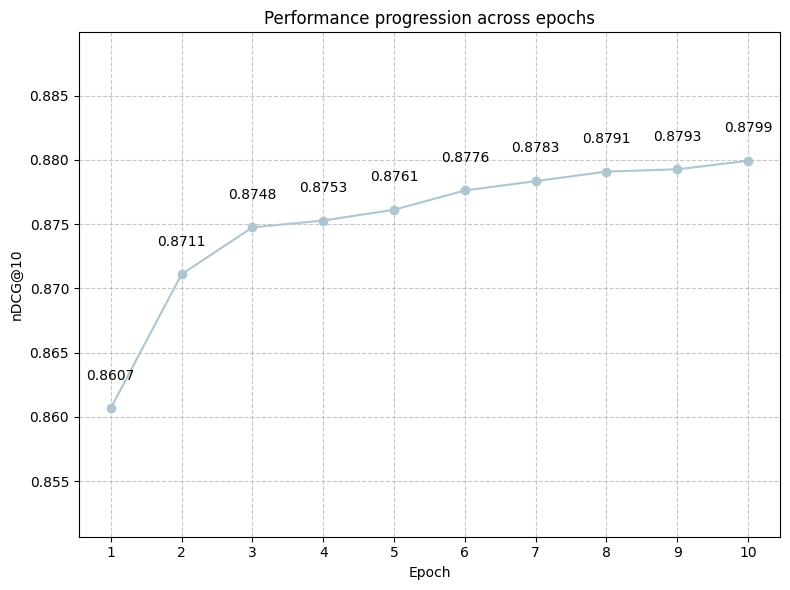

In [39]:
plot_progression(
    source="/media/torontoai/ali/contrastors/benchmark/nc2/run15-chemical-finetune-pair/mean_scores.csv",
)

In [37]:

df = pd.read_csv(
    "/media/torontoai/ali/contrastors/benchmark/chemteb/run15-chemical-finetune-pair/raw_scores.csv", index_col=0)

df_retrieval = df[df.index.str.contains("Retrieval")]
df_retrieval_mean = df_retrieval.mean(axis=0).to_frame()

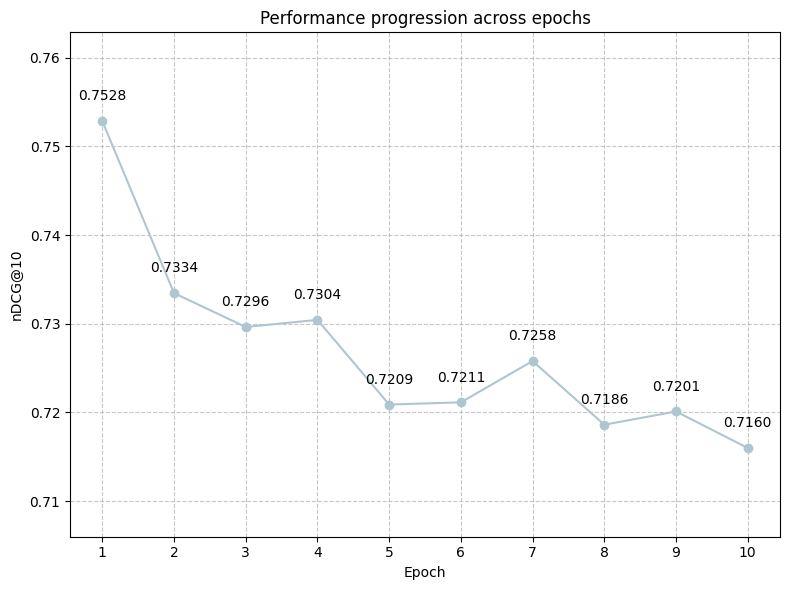

In [38]:
plot_progression(
    source=df_retrieval_mean,
    # ylabel="MTEB Score",
)